# Import of Packages for Feature Extraction


The cell below allows the user to mount GDrive to access files from there.

In [ ]:
# Mount drive at beginning to be able to access csv of post files.
# Google Colab paths
# # # Mount GDrive and attach it to the colab for data I/O
# from google.colab import drive
# drive.mount('/content/drive')
# data_folder = '/content/drive/My Drive/ML4HC_Final_Project/data/input/' #when running on Google Drive

# Open Science Framework path
data_folder = './data/input/reddit_mental_health_dataset/' #if you want to re-extract, posts are here. 
output_dir = f'./data/input/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Import the necessary packages from installed Colab packages. If needed, install stanza and textacy as they are not automatically included in Google Colab.

In [ ]:
import string
import os
import re
import pandas as pd
import numpy as np
import datetime
!pip install stanza textacy
import stanza
import textacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer



     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 215kB 11.2MB/s 
     |████████████████████████████████| 3.0MB 11.3MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 481kB 26.3MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.10.1-cp36-cp36m-linux_x86_64.whl size=1233731 sha256=37a69b99504a14be39251bb22b080a0ffd2dc7f048b3ee7d8147e0ab50eab48c
  Stored in directory: /root/.cache/pip/wheels/64/2a/18/d962b614e055577e7d9a3e4813e0742f822ca9c8800cc3783a
Successfully built cytoolz


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Load in all of the packages related to nltk, stemmer, liwc, and sentiment analysis. This will allow us to extract the specified features.

In [ ]:
# Do this once at the beginning so we don't reload for each post
nltk.download('vader_lexicon')
nltk.download('stopwords')
stanza.download('en') # download English model
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner') # nlp = stanza.Pipeline('en') # initialize English neural pipeline with entity recog NER

stemmer = SnowballStemmer(language='english')

input_path_liwc = '/content/drive/My Drive/ML4HC_Final_Project/data/input/liwc_english_dictionary/' #you must obtain a LIWC license to use the dictionary
liwc_dict = np.load(input_path_liwc + 'liwc.npy', allow_pickle=True).item()
liwc_categories = list(liwc_dict.keys())
liwc_categories.sort()

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2020-06-17 19:41:43 INFO: Downloading default packages for language: en (English)...
2020-06-17 19:43:11 INFO: Finished downloading models and saved to /root/stanza_resources.
2020-06-17 19:43:11 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2020-06-17 19:43:12 INFO: Use device: cpu
2020-06-17 19:43:12 INFO: Loading: tokenize
2020-06-17 19:43:12 INFO: Loading: ner
2020-06-17 19:43:12 INFO: Done loading processors!


# Methods for Feature Extraction

The methods below are helpful for feature extraction of word count, punctuation count, and LIWC category count.

In [ ]:
# Count number times a specific phrase appears in the text.
def count_words(doc,phrases=[]):
    # remove punctuation except apostrophes because we need to search for things like "don't want to live"
    text = re.sub("[^\w\d'\s]+",'',doc.lower())
    counter = 0
    for phrase in phrases:
      counter += text.count(phrase)
    return counter

# Count number of times punctuation appears in the text
def punctuation_count(doc):
    d = {}
    punctuation = '!"#$%&()*+,-./:;=?@[\]^`{|}~' #removed ', <>, _ because m_c_a_t doesnt reflect punctuation really
    for c in doc:
        if c in punctuation:
            if c not in d:
                d[c] = 0
            d[c] += 1
    total = np.sum(list(d.values()))
    return total

# Count the number of words that belong to LIWC categories.
def liwc(liwc_path=None, document=None):
    liwc_vector = []
    # tokenize and stem
    document_tokenized = [n.strip(string.punctuation).lower() for n in document.split()]
    document_stemmed = [stemmer.stem(word) for word in document_tokenized]
    for category in liwc_categories:
        counter  = 0
        # for each word in category, check if its in stemmed sentence list
        counter_doc = np.sum([sum(word.rstrip()==s for s in document_stemmed) for word in liwc_dict.get(category)])
        counter += counter_doc
        liwc_vector.append(counter)
    
    return liwc_vector

The method below will create a TFIDF for train and test sets of documents.

In [ ]:
def tfidf(X_train_sentences = [], X_test_sentences=[], lower_case = True, ngram_range = (1,2), max_features=512, min_df=2, max_df=0.8, model = 'vector'):
    """
    TfidfVectorizer is CountVectorizer followed by TfidfTransformer, The former converts text documents to a sparse matrix of token counts.
    This sparse matrix is then put through the TfidfTransformer which converts a count matrix to a normalized Term Frequency-Inverse Document Frquency(tf)  
    representation which is a metric of word importance. 
    We fit_transform on train_sentences and transform on test sentences to prevent overfitting, X_test_sentences can be None

    Token pattern can be included to include apostophes: token_pattern=r"\b\w[\w']+\b"
    
    model: {vector, sequential} depending on what model takes as input: vector (svm, random forest), sequential (lstm)
    """
    sw = stopwords.words('english')

    if model == 'sequential':
        #         
        vectorizer = TfidfVectorizer(lowercase=lower_case, ngram_range=ngram_range, stop_words=sw,
                                     max_features=max_features, min_df=min_df, max_df=max_df, analyzer=lambda x: x)
        train_vectors = vectorizer.fit_transform(X_train_sentences).toarray()
        if X_test_sentences:
            test_vectors = vectorizer.transform(X_test_sentences).toarray()

    else:
        # model = 'vector'         
        vectorizer = TfidfVectorizer(lowercase=lower_case, ngram_range=ngram_range, stop_words=sw,
                                     max_features=max_features, min_df=min_df, max_df=max_df)
        train_vectors = vectorizer.fit_transform(X_train_sentences).toarray()
        if X_test_sentences:
            test_vectors = vectorizer.transform(X_test_sentences).toarray()
    # train_vectors = vectorizer.fit_transform(X_train_sentences.ravel()).toarray()
    # test_vectors = vectorizer.transform(X_test_sentences.ravel()).toarray()
    feature_names = vectorizer.get_feature_names()
    feature_names = ['tfidf_'+n for n in feature_names]
    if X_test_sentences:
        return train_vectors, test_vectors, feature_names
    else:
        return train_vectors, feature_names, vectorizer


The method below lists the feature names based on the list of features we are trying to extract.

In [ ]:
def extract_NLP_features_names(features):
    feature_names  = []

    if  'readability' in features:
      feature_names.append(['automated_readability_index', 'coleman_liau_index', 'flesch_kincaid_grade_level', 'flesch_reading_ease', 
                            'gulpease_index', 'gunning_fog_index', 'lix', 'smog_index', 'wiener_sachtextformel'])

    if 'basic_count' in features:
      #todo: should we be worried 
      feature_names.append(['n_chars', 'n_long_words', 'n_monosyllable_words', 'n_polysyllable_words', 'n_sents', 'n_syllables', 'n_unique_words', 'n_words'])

    
    if 'sentiment' in features:
        names = ['sent_neg','sent_neu', 'sent_pos', 'sent_compound']
        feature_names.append(names)
        
    if 'covid19' in features:
        feature_names.append(['covid19_total'])

    if 'economic_stress' in features:
        feature_names.append(['economic_stress_total'])

    if 'isolation' in features:
        feature_names.append(['isolation_total'])

    if 'substance_use' in features:
        feature_names.append(['substance_use_total'])

    if 'guns' in features:
        feature_names.append(['guns_total' ])

    if 'domestic_stress' in features:
        feature_names.append(['domestic_stress_total' ])

    if 'suicidality' in features:
        feature_names.append(['suicidality_total'])
        
    if 'punctuation' in features:
        feature_names.append(['punctuation'])
        
    if 'liwc' in features:
        liwc_names = ['liwc_'+n for n in liwc_categories]
        feature_names.append(liwc_names)

    feature_names = [label for item in feature_names for label in item]
    return feature_names


    

The method below extracts out a feature vector for a specified post based on the features that have been specified.

In [ ]:
def extract_NLP_features(doc, features):
    feature_vector = []

    if 'basic_count' or  'readability' in features:
        doc_ts = textacy.make_spacy_doc(doc, lang='en')
        ts = textacy.TextStats(doc_ts)

        if  'readability' in features:
          '''
          described here: https://chartbeat-labs.github.io/textacy/build/html/api_reference/misc.html
          {'flesch_kincaid_grade_level': 15.56027397260274,
          'flesch_reading_ease': 26.84351598173518,
          'smog_index': 17.5058628484301,
          'gunning_fog_index': 20.144292237442922,
          'coleman_liau_index': 16.32928468493151,
          'automated_readability_index': 17.448173515981736,
          'lix': 65.42922374429223,
          'gulpease_index': 44.61643835616438,
          'wiener_sachtextformel': 11.857779908675797}
          '''
          try:
            dictionary = ts.readability_stats
            v_sorted = dict(sorted(dictionary.items())).values()
            feature_vector.append(v_sorted)
          except:
            return []

        if 'basic_count' in features:
          # https://chartbeat-labs.github.io/textacy/build/html/getting_started/quickstart.html
          '''
          {'n_sents': 3,
          'n_words': 73,
          'n_chars': 414,
          'n_syllables': 134,
          'n_unique_words': 57,
          'n_long_words': 30,
          'n_monosyllable_words': 38,
          'n_polysyllable_words': 19}
          '''
          try:
            dictionary = ts.basic_counts
            v_sorted = dict(sorted(dictionary.items())).values() #just in case it outputs the values in a diff order each time
            feature_vector.append(v_sorted)
          except:
            return []

    
    if 'sentiment' in features:
        # don't lowercase or remove punctuation, but maybe preprocess emojis     
        scores = sid.polarity_scores(doc)
        names = ['sent_neg','sent_neu', 'sent_pos', 'sent_compound']
        feature_vector.append(scores.values())
        feature_names.append(names)
        
    if 'covid19' in features:
        words = ['corona','virus','viral','covid', 'sars','influenza','pandemic', 'epidemic', 
         'quarantine','lockdown', 'distancing', 'national emergency', 'flatten', 
             'infect','ventilator', 'mask','symptomatic',
            'epidemiolog', 'immun', 'incubation', 'transmission','vaccine', ]

        counter = count_words(doc,phrases=words)
        feature_vector.append([counter])
        feature_names.append(['covid19_total'])


    if 'economic_stress' in features:
      # Double check that words like "rent" aren't capturing too many other words like "parent". If so replace "rent" with "pay rent" and variations
        words = ['unemploy','employ', 'economy','rent', 'mortgage', 'evict',  "enough money", "more money", 
                 'pay the bills', 'owe', 'debt', "make ends meet", "pay the bills", "afford", "save enough", 
                 'salary', 'wage', 'income', 'job', 'eviction']
        counter = count_words(doc,phrases=words)
        feature_vector.append([counter])
        feature_names.append(['economic_stress_total'])

    if 'isolation' in features:
        words=['alone', 'lonely','no one cares about me','no one cares', "can't see anyone", 
               "can't see my", "i miss my", "i want to see my", "trapped", "i'm in a cage",
              'lonely', "feel ignored","ignoring me" "ugly", 'rejected', "avoid", 'avoiding me', " lack of social",
               'am single', 'been single', 'quarantine', 'lockdown', 'isolation', 'self-isolation']
        counter = count_words(doc,phrases=words)
        feature_vector.append([counter])
        feature_names.append(['isolation_total'])

    if 'substance_use' in features:
        words = ['smoke', 'cigarette', 'tobacco','wine','drink', 'beer', 'alcohol', 'drug', 'opioid', 
                 'cocaine','snort', 'vodka', 'whiskey', 'whisky', 'tequila', 'meth'] #(remove words like drug that may refer to when people are talking about possible covid19 drugs?)
        # we could include commonly abused prescription drugs but this would also capture healthy/prescribed use: https://www.mayoclinic.org/diseases-conditions/prescription-drug-abuse/symptoms-causes/syc-20376813
        counter = count_words(doc,phrases=words)
        feature_vector.append([counter])
        feature_names.append(['substance_use_total'])

    if 'guns' in features:
        words = ['gun', 'pistol', 'revolver', 'semiautomatic', 'rifle', 'shoot', 'firearm', 'semi-automatic']
        counter  = count_words(doc,phrases=words)
        feature_vector.append([counter])
        feature_names.append(['guns_total'])


    if 'domestic_stress' in features:
        words = ['divorce','domestic violence', 'abuse', 'yelling','fighting with my',
                 "we're fighting",  'single mom', 'single dad', 'single parent', 'hit me', 
                 'slapped me', 'fighting', 'fight']
        counter = count_words(doc,phrases=words)
        feature_vector.append([counter ])
        feature_names.append(['domestic_stress_total' ])


    if 'suicidality' in features:
        words = ['commit suicide', 'jump off a bridge', 'I want to overdose',"i'm a burden",
                 "i'm such a burden", 'I will overdose', 'thinking about overdose', 'kill myself', 
                 'killing myself', 'hang myself', 'hanging myself', 'cut myself', 'cutting myself', 
                 'hurt myself', 'hurting myself', 'want to die', 'wanna die', "don't want to wake up", 
                 "don't wake up", 'never want to wake up', "don't want to be alive", 'want to be alive anymore', 
                 'wish it would all end', 'done with living', 'want it to end', 'it all ends tonight', 'end my life', 
                 'live anymore', 'living anymore', 'life anymore', 'be dead', 'take it anymore', 'think about death', 
                 'hopeless', 'hurt myself', "no one will miss me", "don't want to wake up", 
                 'if I live or die', 'i hate my life', 'shoot me', 'kill me', 'suicide',
                 'no point']
        counter = count_words(doc,phrases=words)
        feature_vector.append([counter])
        feature_names.append(['suicidality_total'])
        
    
    if 'punctuation' in features:
        count = punctuation_count(doc)
        feature_vector.append([count])
        feature_names.append(['punctuation'])
        
    if 'liwc' in features:
        vector = liwc(liwc_path = None, document = doc)
        feature_vector.append(vector)
        # feature_names.append(names)
        
    
        
    feature_vector = [n for i in feature_vector for n in i]
    return feature_vector



    

# Extract Out Features

The script below extracts out the features for sentiment, punctuation, LIWC, count based on textacy, readability features based on textacy, and counts based on the lexicons we have developed.

In [ ]:
features = ['sentiment', 'punctuation', 'liwc', 'basic_count', 'readability', 'isolation', 'suicidality', 'economic_stress', 'substance_use', 'guns', 'domestic_stress']

input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/raw_post/'
output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/'
files  = os.listdir(input_dir)
files = [ 'depression_2019.csv',
 'psychosis_2019.csv',
 'anxiety_2019.csv']
for file in files:
    df_subreddit = pd.read_csv(input_dir + file)
    print(df_subreddit.head())
    
    #pre-process to remove duplicate posters, any bots, and posts that have the word quote
    df_subreddit = df_subreddit.drop_duplicates(subset="author")
    df_subreddit = df_subreddit[~df_subreddit.post.str.contains('(?i)bot')]
    df_subreddit = df_subreddit[~df_subreddit.post.str.contains('(?i)quote')]
    
    #process all posts
    posts = list(df_subreddit.post)
    posts = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in posts]

    feature_names = extract_NLP_features_names(features)
    full_column_names = list(df_subreddit.columns) + feature_names
    subreddit_features = pd.DataFrame(columns=full_column_names)

    for pi in range(len(posts)):
      post = posts[pi]
      feature_vector = extract_NLP_features(post, features) #removed feature_names from output
      if len(feature_vector) != 0:
        raw_series = list(df_subreddit.iloc[pi])
        subreddit_features = subreddit_features.append(pd.Series(raw_series + feature_vector, index=full_column_names), ignore_index=True)  

    subreddit_features.to_csv(os.path.join(output_dir, os.path.splitext(file)[0] + "_features.csv"), index=False)       


    
        
        
        

The script below extracts out word counts for the topics we are interested in.

In [ ]:
features = ['covid19', 'isolation', 'suicidality', 'economic_stress', 'substance_use', 'guns', 'domestic_stress']

input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/raw_post/'
output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/phrases_folder'
files  = os.listdir(input_dir)

files = [f for f in files if '_pre.csv' in f]
for file in files:
    df_subreddit = pd.read_csv(input_dir + file)
    print(df_subreddit.head())
    posts = list(df_subreddit.post)
    posts = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in posts] 

    feature_names = extract_NLP_features_names(features)
    full_column_names = list(df_subreddit.columns) + feature_names
    subreddit_features = pd.DataFrame(columns=full_column_names)

    for pi in range(len(posts)):
      post = posts[pi]
      feature_vector = extract_NLP_features(post, features)
      raw_series = list(df_subreddit.iloc[pi])
      subreddit_features = subreddit_features.append(pd.Series(raw_series + feature_vector, index=full_column_names), ignore_index=True)  

    subreddit_features.to_csv(os.path.join(output_dir, os.path.splitext(file)[0] + "_phrases.csv"), index=False)      

The script below extracts out TF-IDF vectors for training and test data.



In [ ]:
features = ['tfidf']

# input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/raw_post/'
# output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/tfidf_vector/'
files  = os.listdir(input_dir)
files = [f for f in files if '.csv' in f]
end_date = datetime.datetime(2020, 1, 15)

all_posts = pd.read_csv(input_dir + files[0], index_col=False)
all_posts = all_posts[~all_posts['post'].str.contains("deleted")]
all_posts['post_stemmed'] = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in all_posts['post']]
all_posts['post_stemmed'] = [' '.join([stemmer.stem(word.strip(string.punctuation).lower()) for word in p.split()]) for p in all_posts['post_stemmed']]
print(all_posts.shape)

for file in files[1:]:
    df_subreddit = pd.read_csv(input_dir + file, index_col=False);
    df_subreddit['post_stemmed'] = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in df_subreddit['post']]
    df_subreddit['post_stemmed'] = [' '.join([stemmer.stem(word.strip(string.punctuation).lower()) for word in p.split()]) for p in df_subreddit['post_stemmed']]
    print(df_subreddit.shape)
    all_posts = pd.concat([all_posts, df_subreddit], axis=0)
    print(all_posts.shape)

all_posts.head()

all_posts['date'] = pd.to_datetime(all_posts['date'], format="%Y/%m/%d")

all_posts_training = list(all_posts['post_stemmed'].loc[all_posts['date'] <= end_date])

all_posts_testing = list(all_posts['post_stemmed'].loc[all_posts['date'] > end_date])
    
'''
tfidf is done with the whole corpus, not for each sentence, or with the whole train set (if we're doing a split, which we may not be for cluster analysis). 

play with the params a bit to figure out how many max_features so that it's not too sparse and captures important words per subreddit. 
'''
train_vectors, test_vectors, features = tfidf(X_train_sentences = all_posts_training, X_test_sentences=all_posts_testing, lower_case = True, 
                                              ngram_range = (1,2), max_features=None, min_df=2, max_df=0.8, model = 'vector')

all_posts_new = all_posts
all_posts_new = all_posts_new.reindex(all_posts_new.columns.tolist() + features, axis=1)
all_posts_new.loc[all_posts['date'] <= end_date,features] = train_vectors
all_posts_new.loc[all_posts['date'] > end_date, features] = test_vectors

all_posts_new.to_csv(os.path.join(output_dir, "tfidf_test.csv"), index=False)

The two cells below will do TFIDF on the pre-pandemic mental health subreddits, and then apply that vectorizer to the entire dataset and to individual subreddits both pre- and mid-pandemic.


In [ ]:
features = ['tfidf']
min_posts = 2720 # from bipolarreddit
feats = [256, 512, 1024]

for feat in feats:
  # input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/new'

  files = ['suicidewatch_pre_features.csv',
          'depression_pre_features.csv',
          'ptsd_pre_features.csv',
          'anxiety_pre_features.csv',
          'socialanxiety_pre_features.csv',
          'healthanxiety_pre_features.csv',
          'bipolarreddit_pre_features.csv',
          'bpd_pre_features.csv',
          'schizophrenia_pre_features.csv',
          'EDAnonymous_pre_features.csv',
          'alcoholism_pre_features.csv',
          'addiction_pre_features.csv',
          'adhd_pre_features.csv']

  # gather all posts from pre_pandemic
  all_posts = pd.read_csv(os.path.join(input_dir, files[0]), index_col=False)
  all_posts = all_posts.sample(min_posts)
  all_posts['post_stemmed'] = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in all_posts['post']]
  all_posts['post_stemmed'] = [' '.join([stemmer.stem(word.strip(string.punctuation).lower()) for word in p.split()]) for p in all_posts['post_stemmed']]
  print(all_posts.shape)

  for file in files[1:]:
      df_subreddit = pd.read_csv(os.path.join(input_dir, file), index_col=False);
      df_subreddit = df_subreddit.sample(min_posts)
      df_subreddit['post_stemmed'] = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in df_subreddit['post']]
      df_subreddit['post_stemmed'] = [' '.join([stemmer.stem(word.strip(string.punctuation).lower()) for word in p.split()]) for p in df_subreddit['post_stemmed']]
      all_posts = pd.concat([all_posts, df_subreddit], axis=0)
      print(all_posts.shape)

  all_posts.head()

  posts = list(all_posts.post_stemmed)

  train_vectors, features, vectorizer = tfidf(X_train_sentences = posts, lower_case = True, 
                                  ngram_range = (1,2), max_features=feat, min_df=0.001, max_df=0.75, model = 'vector')

  # input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/new/'
  # output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/tfidf_combined'
  files  = os.listdir(input_dir)

  files = [f for f in files if '.csv' in f]
  for file in files:
      df_subreddit = pd.read_csv(os.path.join(input_dir + file))
      print(df_subreddit.head())
      posts = list(df_subreddit.post)
      if len(posts) == 0:
        continue
      posts = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in posts] 
      posts = [' '.join([stemmer.stem(word.strip(string.punctuation).lower()) for word in p.split()]) for p in posts]

      tfidf_posts = vectorizer.transform(posts).toarray()
      df_subreddit_new = df_subreddit
      df_subreddit_new = df_subreddit_new.reindex(df_subreddit_new.columns.tolist() + features, axis=1)
      df_subreddit_new.loc[:, features] = tfidf_posts

      df_subreddit_new.to_csv(os.path.join(output_dir, os.path.splitext(file)[0] + "_tfidf_{}.csv".format(feat)), index=False)
  
  import pickle
  pickle.dump(vectorizer.vocabulary_,open(os.path.join("/content/drive/My Drive/ML4HC_Final_Project/data/input/lda_models", "vec_{}.pkl".format(feat)),"wb"))   

In [ ]:
# input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/new/'
# output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/tfidf_combined'
files  = os.listdir(input_dir)

files = [f for f in files if '.csv' in f]
for file in files:
    df_subreddit = pd.read_csv(os.path.join(input_dir + file))
    print(df_subreddit.head())
    posts = list(df_subreddit.post)
    if len(posts) == 0:
      continue
    posts = [post.replace('\n', ' ').replace('  ',' ').replace('“', '').replace('”', '') for post in posts] 
    posts = [' '.join([stemmer.stem(word.strip(string.punctuation).lower()) for word in p.split()]) for p in posts]

    tfidf_posts = vectorizer.transform(posts).toarray()
    df_subreddit_new = df_subreddit
    df_subreddit_new = df_subreddit_new.reindex(df_subreddit_new.columns.tolist() + features, axis=1)
    df_subreddit_new.loc[:, features] = tfidf_posts

    df_subreddit_new.to_csv(os.path.join(output_dir, os.path.splitext(file)[0] + "_tfidf_all.csv"), index=False)      

In [ ]:
# save vectorizer
import pickle
pickle.dump(vectorizer.vocabulary_,open(os.path.join("/content/drive/My Drive/ML4HC_Final_Project/data/input/lda_models", "vec_all.pkl"),"wb"))

In [ ]:
file

'depression_2018.csv'

# Create Histograms of Data

The following two cells create the histograms for the number of posts that are present in each subreddit in the pre- and mid-pandemic timeframes.

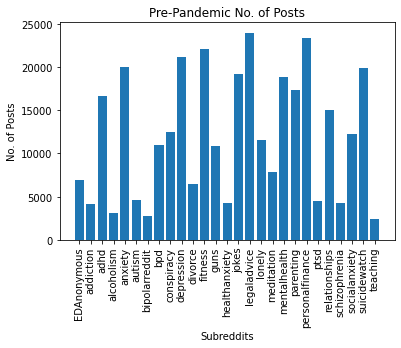

In [ ]:
files = ['suicidewatch_pre_features.csv',
 'depression_pre_features.csv',
 'ptsd_pre_features.csv',
 'anxiety_pre_features.csv',
 'socialanxiety_pre_features.csv',
 'healthanxiety_pre_features.csv',
 'bipolarreddit_pre_features.csv',
 'bpd_pre_features.csv',
 'schizophrenia_pre_features.csv',
 'EDAnonymous_pre_features.csv',
 'alcoholism_pre_features.csv',
 'addiction_pre_features.csv',
 'adhd_pre_features.csv',
 'mentalhealth_pre_features.csv',
 'meditation_pre_features.csv',
 'personalfinance_pre_features.csv',
 'teaching_pre_features.csv',
 'relationships_pre_features.csv',
 'legaladvice_pre_features.csv',
 'fitness_pre_features.csv',
 'parenting_pre_features.csv',
 'lonely_pre_features.csv',
 'autism_pre_features.csv',
 'divorce_pre_features.csv',
 'conspiracy_pre_features.csv',
 'guns_pre_features.csv',
 'jokes_pre_features.csv'
]

input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/new/'
# files  = os.listdir(input_dir)
# files = [f for f in files if '.csv' in f]

file_count_dict = {}
for file in files:
    df_subreddit = pd.read_csv(input_dir + file, index_col=False);
    file_count_dict[os.path.basename(file).split('_')[0]] = df_subreddit.shape[0]

import matplotlib.pyplot as plt
# file_count_dict['COVID19_support'] = file_count_dict['COVID19\_support']
# file_count_dict.pop('COVID19\_support', None)
sorted_values = [x for _,x in sorted(zip(file_count_dict.keys(),file_count_dict.values()))]
plt.bar(sorted(file_count_dict.keys()), sorted_values)
plt.xticks(rotation=90)
plt.title('Pre-Pandemic No. of Posts')
plt.xlabel('Subreddits')
plt.ylabel('No. of Posts')
plt.show()

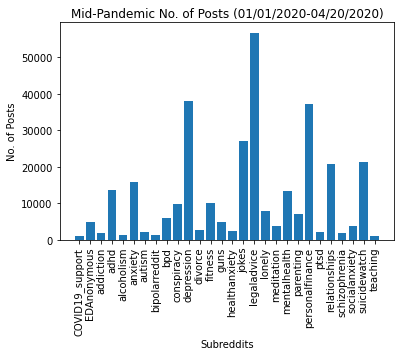

In [ ]:
files = ['suicidewatch_post_features.csv',
 'depression_post_features.csv',
 'ptsd_post_features.csv',
 'anxiety_post_features.csv',
 'socialanxiety_post_features.csv',
 'healthanxiety_post_features.csv',
 'bipolarreddit_post_features.csv',
 'bpd_post_features.csv',
 'schizophrenia_post_features.csv',
 'EDAnonymous_post_features.csv',
 'alcoholism_post_features.csv',
 'addiction_post_features.csv',
 'adhd_post_features.csv',
 'mentalhealth_post_features.csv',
 'meditation_post_features.csv',
 'personalfinance_post_features.csv',
 'teaching_post_features.csv',
 'relationships_post_features.csv',
 'legaladvice_post_features.csv',
 'fitness_post_features.csv',
 'parenting_post_features.csv',
 'lonely_post_features.csv',
 'autism_post_features.csv',
 'divorce_post_features.csv',
 'conspiracy_post_features.csv',
 'COVID19_support_post_features.csv',
 'guns_post_features.csv',
 'jokes_post_features.csv'
]

input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/new/'
# files  = os.listdir(input_dir)
# files = [f for f in files if '.csv' in f]

start_date = datetime.datetime(2020, 3, 11)

file_count_dict = {}
for file in files:
    df_subreddit = pd.read_csv(input_dir + file, index_col=False);
    # df_subreddit['date'] = pd.to_datetime(df_subreddit['date'], format="%Y/%m/%d")
    # df_subreddit = df_subreddit.loc[df_subreddit['date'] >= start_date]
    file_count_dict[os.path.basename(file).split('_')[0]] = df_subreddit.shape[0]

import matplotlib.pyplot as plt
file_count_dict['COVID19_support'] = file_count_dict['COVID19']
file_count_dict.pop('COVID19', None)
sorted_values = [x for _,x in sorted(zip(file_count_dict.keys(),file_count_dict.values()))]
plt.bar(sorted(file_count_dict.keys()), sorted_values)
plt.xticks(rotation=90)
plt.title('Mid-Pandemic No. of Posts (01/01/2020-04/20/2020)')
plt.xlabel('Subreddits')
plt.ylabel('No. of Posts')
plt.show()

In [ ]:
files = ['suicidewatch_pre_features.csv',
 'depression_pre_features.csv',
 'ptsd_pre_features.csv',
 'anxiety_pre_features.csv',
 'socialanxiety_pre_features.csv',
 'healthanxiety_pre_features.csv',
 'bipolarreddit_pre_features.csv',
 'bpd_pre_features.csv',
 'schizophrenia_pre_features.csv',
 'EDAnonymous_pre_features.csv',
 'alcoholism_pre_features.csv',
 'addiction_pre_features.csv',
 'adhd_pre_features.csv',
 'mentalhealth_pre_features.csv',
 'meditation_pre_features.csv',
 'personalfinance_pre_features.csv',
 'teaching_pre_features.csv',
 'relationships_pre_features.csv',
 'legaladvice_pre_features.csv',
 'fitness_pre_features.csv',
 'parenting_pre_features.csv',
 'lonely_pre_features.csv',
 'autism_pre_features.csv',
 'divorce_pre_features.csv',
 'conspiracy_pre_features.csv',
 'guns_pre_features.csv',
 'jokes_pre_features.csv',
 'suicidewatch_post_features.csv',
 'depression_post_features.csv',
 'ptsd_post_features.csv',
 'anxiety_post_features.csv',
 'socialanxiety_post_features.csv',
 'healthanxiety_post_features.csv',
 'bipolarreddit_post_features.csv',
 'bpd_post_features.csv',
 'schizophrenia_post_features.csv',
 'EDAnonymous_post_features.csv',
 'alcoholism_post_features.csv',
 'addiction_post_features.csv',
 'adhd_post_features.csv',
 'mentalhealth_post_features.csv',
 'meditation_post_features.csv',
 'personalfinance_post_features.csv',
 'teaching_post_features.csv',
 'relationships_post_features.csv',
 'legaladvice_post_features.csv',
 'fitness_post_features.csv',
 'parenting_post_features.csv',
 'lonely_post_features.csv',
 'autism_post_features.csv',
 'divorce_post_features.csv',
 'conspiracy_post_features.csv',
 'COVID19_support_post_features.csv',
 'guns_post_features.csv',
 'jokes_post_features.csv'
]

input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/new/'

data = pd.read_csv(os.path.join(input_dir, files[0]))
data_agg = data

for file in files[1:]:
    data = pd.read_csv(os.path.join(input_dir, file));
    data_agg = pd.concat([data_agg, data], axis=0, ignore_index=True)

print(data_agg.author.unique().shape)
print(data_agg.shape)

(555349,)
(647653, 95)


In [ ]:
files = ['suicidewatch_pre.csv',
 'depression_pre.csv',
 'ptsd_pre.csv',
 'anxiety_pre.csv',
 'socialanxiety_pre.csv',
 'healthanxiety_pre.csv',
 'bipolarreddit_pre.csv',
 'bpd_pre.csv',
 'schizophrenia_pre.csv',
 'EDAnonymous_pre.csv',
 'alcoholism_pre.csv',
 'addiction_pre.csv',
 'adhd_pre.csv',
 'mentalhealth_pre.csv',
 'meditation_pre.csv',
 'personalfinance_pre.csv',
 'teaching_pre.csv',
 'relationships_pre.csv',
 'legaladvice_pre.csv',
 'fitness_pre.csv',
 'parenting_pre.csv',
 'lonely_pre.csv',
 'autism_pre.csv',
 'divorce_pre.csv',
 'conspiracy_pre.csv',
 'guns_pre.csv',
 'jokes_pre.csv',
 'suicidewatch_post.csv',
 'depression_post.csv',
 'ptsd_post.csv',
 'anxiety_post.csv',
 'socialanxiety_post.csv',
 'healthanxiety_post.csv',
 'bipolarreddit_post.csv',
 'bpd_post.csv',
 'schizophrenia_post.csv',
 'EDAnonymous_post.csv',
 'alcoholism_post.csv',
 'addiction_post.csv',
 'adhd_post.csv',
 'mentalhealth_post.csv',
 'meditation_post.csv',
 'personalfinance_post.csv',
 'teaching_post.csv',
 'relationships_post.csv',
 'legaladvice_post.csv',
 'fitness_post.csv',
 'parenting_post.csv',
 'lonely_post.csv',
 'autism_post.csv',
 'divorce_post.csv',
 'conspiracy_post.csv',
 'COVID19_support_post.csv',
 'guns_post.csv',
 'jokes_post.csv'
]

input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/raw_post'

data = pd.read_csv(os.path.join(input_dir, files[0]))
data_agg = data

for file in files[1:]:
    data = pd.read_csv(os.path.join(input_dir, file));
    data_agg = pd.concat([data_agg, data], axis=0, ignore_index=True)

print(data_agg.author.unique().shape)
print(data_agg.shape)

(636743,)
(1115854, 4)


In [ ]:
327289 + sum(file_count_dict.values())

647653

# Entity Analysis + Computation Complexity

In [ ]:
post = "Mayor Cuomo may lockdown NYC. I live in Brooklyn."
post = nlp(post)
print(*[f'token: {token.text}\tner: {token.ner}' for sent in post.sentences for token in sent.tokens], sep='\n')
print(post.ents)

In [ ]:
# Extract location or other entities
def extract_entity(doc, entity = 'GPE'):   
    # classes although they have different code names like GPE and ORG: (PERSON, LOCATION, ORGANIZATION, MISC), numerical (MONEY, NUMBER, ORDINAL, PERCENT), and temporal (DATE, TIME, DURATION, SET) entities (12 classes).
    # Adding the regexner annotator and using the supplied RegexNER pattern files adds support for the fine-grained and additional entity classes EMAIL, URL, CITY, STATE_OR_PROVINCE, COUNTRY, NATIONALITY, RELIGION, (job) TITLE, IDEOLOGY, CRIMINAL_CHARGE, CAUSE_OF_DEATH, HANDLE (12 classes) for a total of 24 classes.
    
    # Extract locations (don't lowercase doc, won't work for "nyc", only "NYC")
    result = []
    doc = nlp(doc) #nlp was loaded once above
    entitities = doc.ents

    if entity == 'all':
        result = [n.text for n in entitities]
        return result
    else:
        for ent in entitities:
            if ent.type ==entity:
                # append 'NYC'                 
                result.append(ent.text)
        return result
    

In [ ]:


print(extract_entity("I live in Brooklyn, NYC", entity = 'GPE'))
print(extract_entity("I live in Brooklyn, Cuomo's town", entity = 'PERSON'))
print(extract_entity("I live in Brooklyn, Cuomo's town, on April 21st, 1990", entity = 'all'))

['Brooklyn', 'NYC']
['Cuomo']
['Brooklyn', 'Cuomo', 'April 21st, 1990']


In [ ]:
# Measure computation complexity
features = ['sentiment', 'punctuation', 'liwc', 'basic_count', 'readability',  'tfidf', 'covid19', 'suicidality', 'economic_stress', 'substance_use', 'guns', 'domestic_stress']

post = "I'm feeling terrible, what do you think I should do? I think I should call someone!"

for feature in features:  
  print('====='+feature)
  
  %time feature_vector = extract_NLP_features(post, [feature])



# Filter Posts

In [ ]:
input_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/old/'
output_dir = '/content/drive/My Drive/ML4HC_Final_Project/data/input/feature_extraction/new/'
files = [f for f in os.listdir(input_dir) if '.csv' in f]


for f in files:
  df_subreddit = pd.read_csv(os.path.join(input_dir, f))
  #pre-process to remove duplicate posters, any bots, and posts that have the word quote
  df_subreddit = df_subreddit.drop_duplicates(subset="author")
  df_subreddit = df_subreddit[~df_subreddit.post.str.contains('(?i)bot')]
  df_subreddit = df_subreddit[~df_subreddit.post.str.contains('(?i)quote')]

  df_subreddit.to_csv(os.path.join(output_dir, f), index=False)